In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder



In [2]:
df=pd.read_csv('/Users/leahnewmark/ML-Capstone/Real Breast Cancer Data.csv')

In [3]:
print(df.head())

     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.234260   
3  TCGA-D8-A1XR   56  FEMALE  0.345090  -0.21147  -0.19304  0.124270   
4  TCGA-BH-A0BF   56  FEMALE  0.221550   1.90680   0.52045 -0.311990   

  Tumour_Stage                      Histology ER status PR status HER2 status  \
0          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
1           II             Mucinous Carcinoma  Positive  Positive    Negative   
2          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
3           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
4           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   

                  Surgery_type Date_of_Surgery Date_of_Last_Visit  \
0  Modified

In [4]:
# Check for missing values
print("Missing values before dropna:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


Missing values before dropna:
Patient_ID             0
Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64


In [5]:
def check_df(dataframe):
    print(" SHAPE ".center(70,'~'))
    print(dataframe.shape)
    print(" TYPES ".center(70,'~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'~'))
    print(dataframe.head())
    print(" DESCRIBE ".center(70,'~'))
    print(dataframe.describe().T)
check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(317, 16)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Patient_ID             object
Age                     int64
Gender                 object
Protein1              float64
Protein2              float64
Protein3              float64
Protein4              float64
Tumour_Stage           object
Histology              object
ER status              object
PR status              object
HER2 status            object
Surgery_type           object
Date_of_Surgery        object
Date_of_Last_Visit     object
Patient_Status         object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.23426

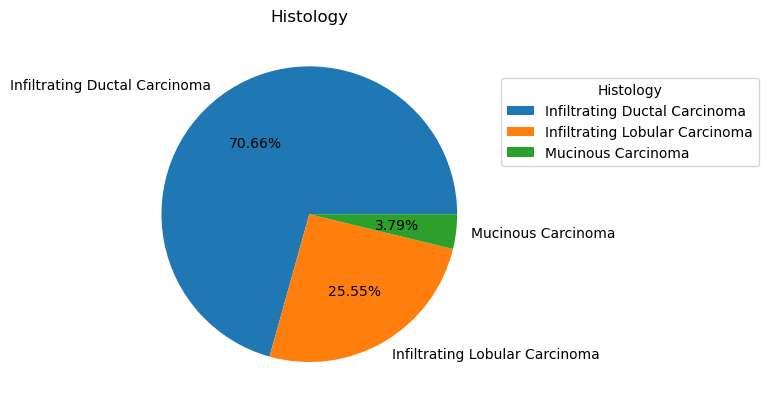

In [6]:
#histology pie chart
df['Histology'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Histology')
plt.ylabel('') #remove y label
plt.legend(title="Histology", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

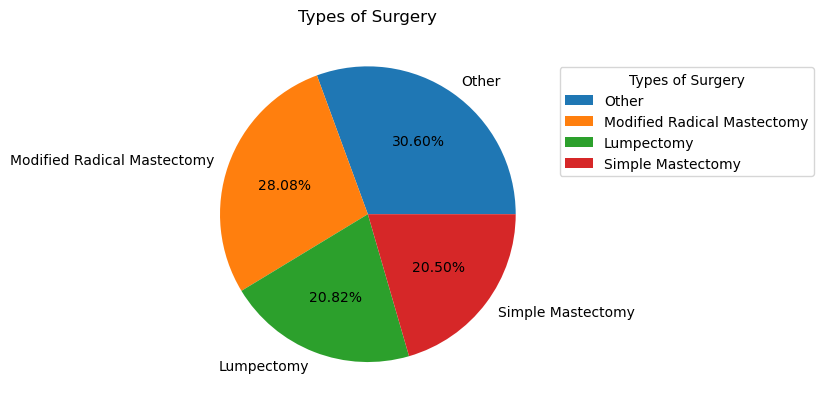

In [7]:
#Type of surgery pie chart
surgery= df['Surgery_type'].value_counts()
transactions= surgery.index
quantity= surgery.values
surgery.plot(kind='pie', autopct='%1.2f%%', title= "Types of Surgery")
plt.ylabel('')
plt.legend(title="Types of Surgery", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

In [8]:
df['Gender'].value_counts()
#Likely no need to include male pts in features, not enough sample

Gender
FEMALE    313
MALE        4
Name: count, dtype: int64

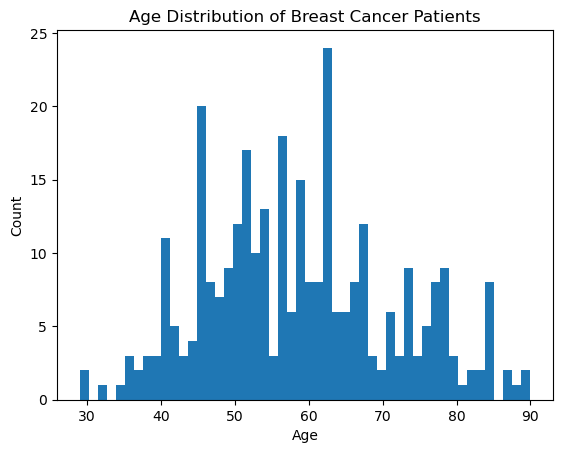

In [9]:
df['Age'].hist(bins = 50, grid = False)
plt.xlabel(xlabel = "Age")
plt.ylabel(ylabel = "Count")
plt.title("Age Distribution of Breast Cancer Patients")
plt.show()

In [10]:
# This was a good idea I picked up from alt code to create multiple pie charts or other future graphs. 

def plot_pie_chart(column, title):
    # define Seaborn color palette to use
    palette_color = sns.color_palette('bright')
  
    # plotting data on chart
    plt.pie(df[column].value_counts(), labels=df[column].unique(), colors=palette_color, autopct='%.0f%%')

    plt.title(title)
    # displaying chart
    plt.show()

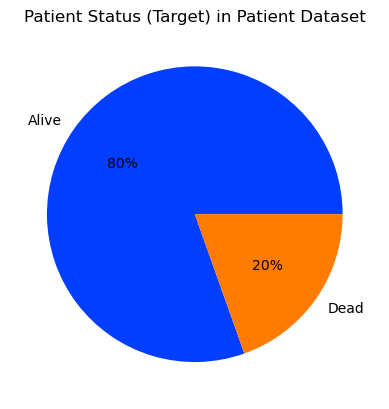

In [11]:
plot_pie_chart("Patient_Status", "Patient Status (Target) in Patient Dataset")
#my code shows 80% living pt, sample code had 79%. 

The target (living, dead) is fairly unbalanced towards patients that are alive. This would make it difficult to properly make classifications without resampling the dataset.

Preprocess 

In [12]:
#make a copy of df and drop uninformative features
df_info= df.copy().drop(columns=['Patient_ID', 'Gender', 'ER status', 'PR status'])
le= LabelEncoder()
#create target variable column
df_info['Patient_Status_le']= le.fit_transform(df_info['Patient_Status'])
df_info['HER2_Status_le'] = le.fit_transform(df_info['HER2 status'])
                            
#Ordinal encode data to keep order of categories 
oe = OrdinalEncoder(dtype=int)
df_info['Tumour_Stage_oe'] = oe.fit_transform(np.array(df_info['Tumour_Stage']).reshape(-1, 1))

df_info.drop(columns=['Tumour_Stage', 'Date_of_Surgery', 'Date_of_Last_Visit'], inplace=True)


In [13]:
df_info= pd.get_dummies(df_info, columns=['Histology'], dtype = int)

sample the data due to imbalance of dead vs living


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier


# Define features and target
target = df_info['Patient_Status_le']
features= df_info.drop(columns=['Patient_Status', 'Patient_Status_le', 'HER2 status', 'Surgery_type'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 42, stratify=df_info['Patient_Status_le'])

# ## Resample dataset so that target feature is evenly distributed
smote = SMOTE(k_neighbors=5, random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)


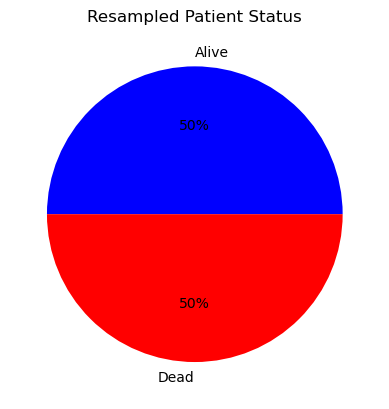

In [15]:
plt.pie(y_train.value_counts(), labels=df_info['Patient_Status'].unique(), colors='bright', autopct='%.0f%%')

plt.title("Resampled Patient Status")
# displaying chart
plt.show()

Check new df shape

In [16]:
# Verify the shape of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (432, 10)
X_test shape: (48, 10)
y_train shape: (432,)
y_test shape: (48,)


Support Vector Classification Model
Best estimator chosen during the fitting/GridSearch shows hyperparameters for the model

In [17]:
from sklearn.svm import SVC
svc = SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, n_jobs=50)
clf.fit(X_train, y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 100], 'kernel': ('linear', 'rbf')})
clf.best_estimator_


SVC(C=1, kernel='linear', probability=True)

Logistic Regression

/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


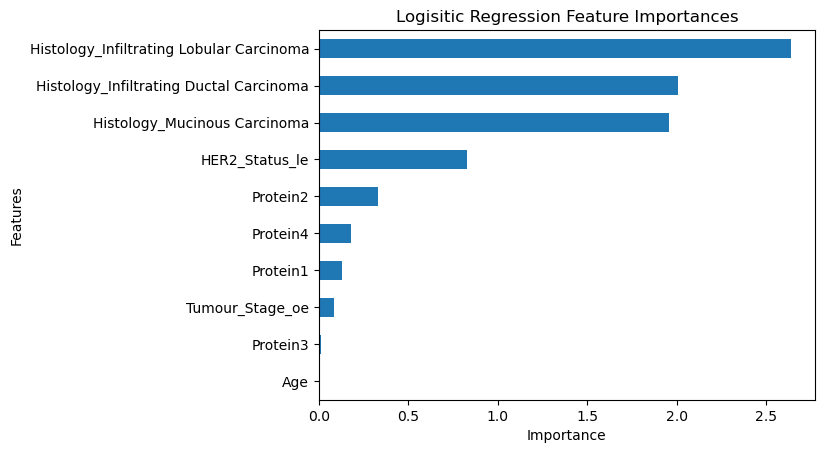

In [18]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=3500, penalty='elasticnet', solver = 'saga', l1_ratio=1)
logit.fit(X_train, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances = pd.Series(index = X_train.columns, data= np.abs(logit_importances))
logit_feature_importances = logit_feature_importances.sort_values(ascending=True)
logit_feature_importances.plot(kind='barh', title = 'Logisitic Regression Feature Importances', xlabel = 'Importance', ylabel = 'Features')
plt.show()

#There appear to be slight differences in totals for each feature in histogram when compared
#to example code, this could be do to resampling, overefitting data. 
#The order of importance of features are also different with protein 3 being less important than Tumour stage in my model. 

Per origincal author: Following training of the Logisitic Regression model on the dataset, the most important features that contribute to classification of Patient Status include Histology of ILC, IDC carcinomas and patient is HER2+/-. Features that don't seem to contribute to the model's prediction include age, stage of tumour. Suprisingly, the stage of a tumour does not seem to contribute much informationally to the model, despite domain knowledge of this feature. This may be due to skewness of the data towards stage III cancer as this is prevalent in ~60% of the patients in the dataset. HER2 status also is a informative input feature for the model as we understand by HER2++ typically as a predictor of cancer cases.

Random Forest Classifier

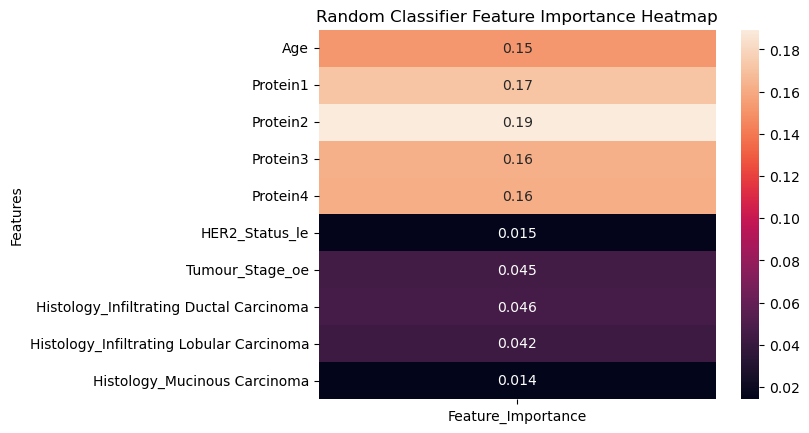

In [19]:
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
forest_feature_importance = pd.DataFrame(index = forest.feature_names_in_, data=forest.feature_importances_, columns = ['Feature_Importance'])
sns.heatmap(forest_feature_importance, annot=True).set(title = "Random Classifier Feature Importance Heatmap", ylabel='Features')
plt.show()

My output is in line with original authors output, showing age and protein and most important features for survival prediction. 

Decison Tree Classifier

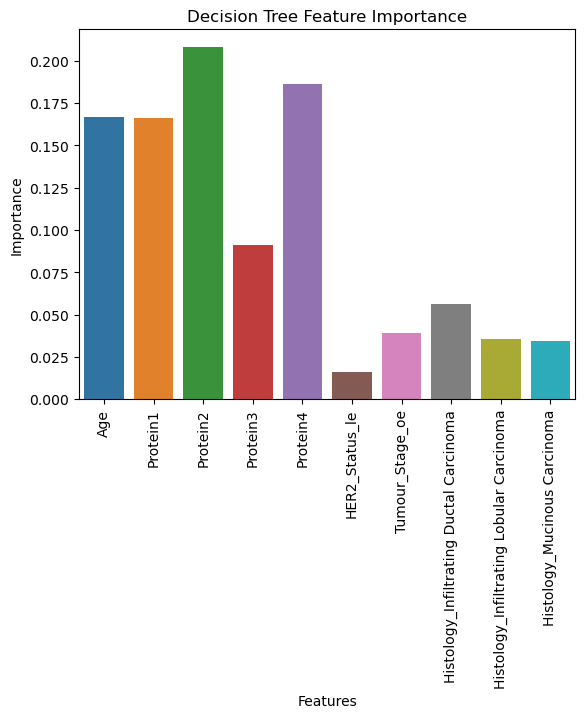

In [20]:
from sklearn.tree import DecisionTreeClassifier
tree_gini = DecisionTreeClassifier(criterion='gini',max_depth=15)
tree_gini.fit(X_train, y_train)
tree_gini_feature_importances = pd.Series(tree_gini.feature_importances_, index=tree_gini.feature_names_in_)

sns.barplot(x = tree_gini.feature_names_in_, y = tree_gini.feature_importances_).set(title = "Decision Tree Feature Importance", xlabel='Features', ylabel='Importance')
plt.xticks(rotation = 90) 
plt.show()

HER2 status le is empty in my code when compared to original author's code. This could be counting for the descrepency. Per original author "Both decision tree classifiers (Decision Tree and Random Forest) produce similar rankings for the importance of the features in the models. Protein 2 expression levels seems to be a driving factor to the classification of patient status, with the other proteins also contributing to the predictions of the model. Opposing to what previously was found from our Logistic Regressor training is that age also contributes to the predictions of the model--this matches to preconceived notion that age also can be a determinant of the patient's outcome with the disease. Interestingly, the lowest scored features for importance are presence of specific carcinoma's (ILC, IDC, MC), HER2 status and stage of the tumour."

In [21]:
from tpot import TPOTClassifier
tpot=TPOTClassifier(generations=3, population_size=5, verbosity=2, offspring_size=10, scoring='accuracy', cv=5)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))


ModuleNotFoundError: No module named 'tpot'

In [23]:
 
def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


Future analysis using ROC curves on models- would like to discuss these curves

def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

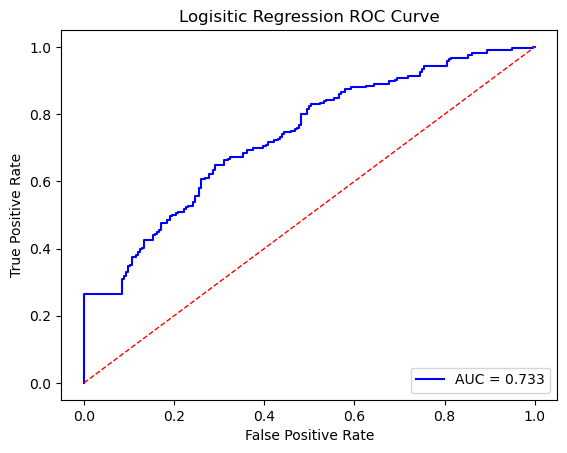

Accuracy Score: 0.6712962962962963
Confusion Matrix:
 [[158  58]
 [ 84 132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69       216
           1       0.69      0.61      0.65       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



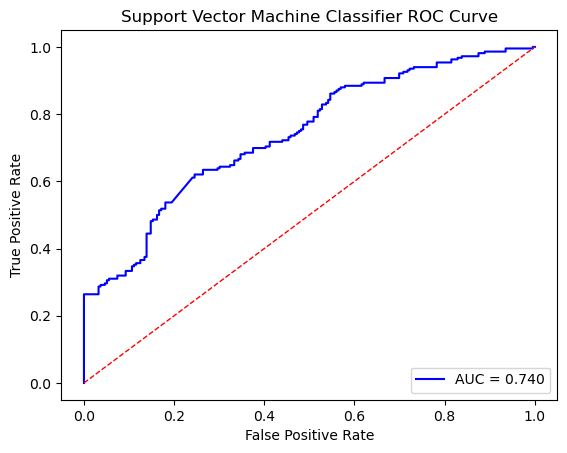

Accuracy Score: 0.6273148148148148
Confusion Matrix:
 [[204  12]
 [149  67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.94      0.72       216
           1       0.85      0.31      0.45       216

    accuracy                           0.63       432
   macro avg       0.71      0.63      0.59       432
weighted avg       0.71      0.63      0.59       432



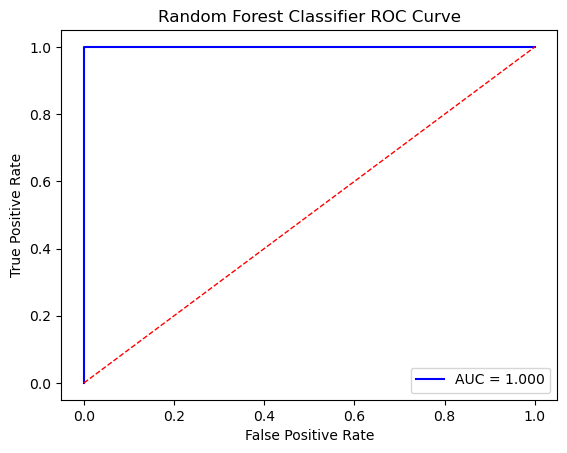

Accuracy Score: 1.0
Confusion Matrix:
 [[216   0]
 [  0 216]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



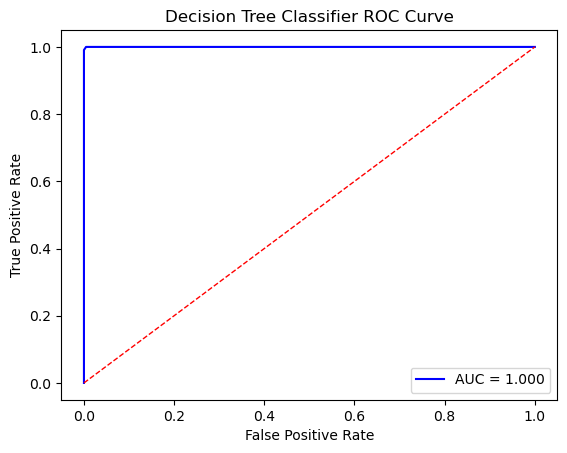

Accuracy Score: 0.9976851851851852
Confusion Matrix:
 [[215   1]
 [  0 216]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=logit.predict(X_train))}")

plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=clf.predict(X_train))}")

plot_ROC(forest, "Random Forest Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=forest.predict(X_train))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=tree_gini.predict(X_train))}")

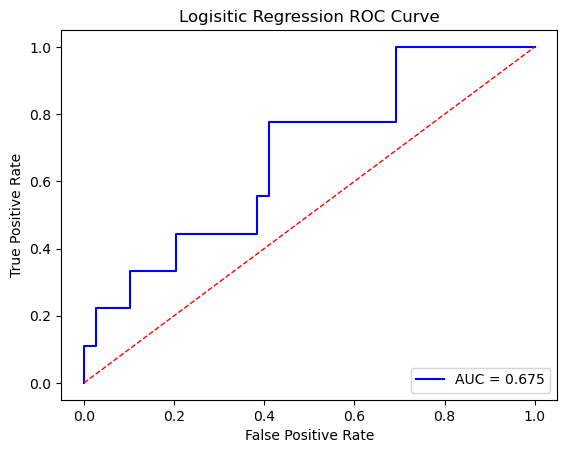

Accuracy Score: 0.7083333333333334
Confusion Matrix:
 [[30  9]
 [ 5  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.31      0.44      0.36         9

    accuracy                           0.71        48
   macro avg       0.58      0.61      0.59        48
weighted avg       0.75      0.71      0.73        48



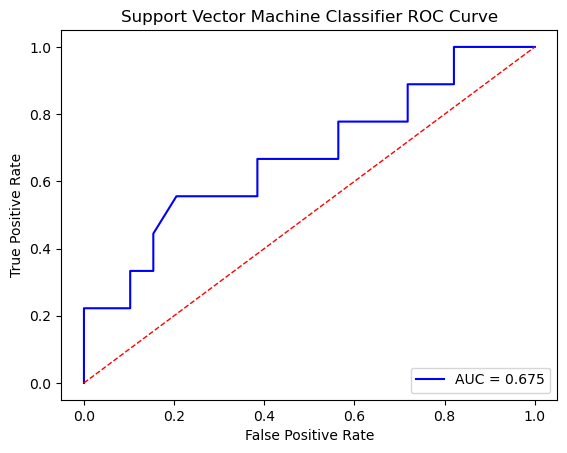

Accuracy Score: 0.7708333333333334
Confusion Matrix:
 [[35  4]
 [ 7  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.33      0.22      0.27         9

    accuracy                           0.77        48
   macro avg       0.58      0.56      0.57        48
weighted avg       0.74      0.77      0.75        48



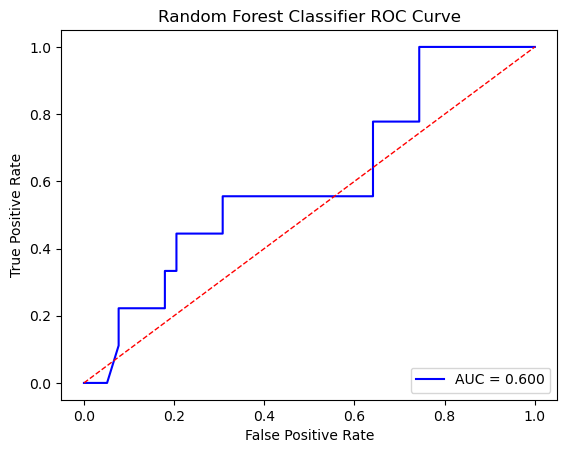

Accuracy Score: 0.7708333333333334
Confusion Matrix:
 [[37  2]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        39
           1       0.00      0.00      0.00         9

    accuracy                           0.77        48
   macro avg       0.40      0.47      0.44        48
weighted avg       0.65      0.77      0.71        48



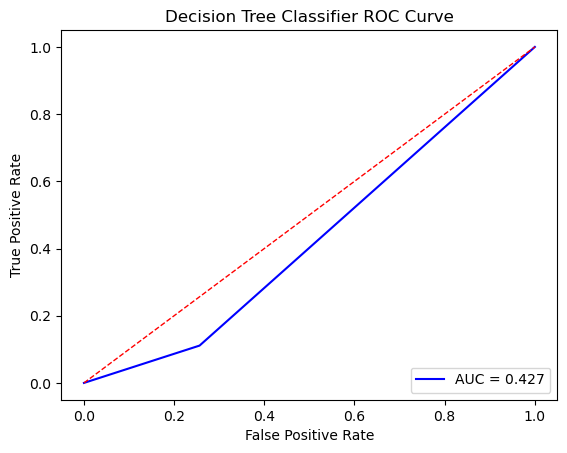

Accuracy Score: 0.625
Confusion Matrix:
 [[29 10]
 [ 8  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76        39
           1       0.09      0.11      0.10         9

    accuracy                           0.62        48
   macro avg       0.44      0.43      0.43        48
weighted avg       0.65      0.62      0.64        48



In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test))}")

plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=clf.predict(X_test))}")

plot_ROC(forest, "Random Forest Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test))}")

Curves showing stair set could indicate that we are overfitting on small amount of data and need more samples. 

Logistic regression classification report: Precision- out of all the features that the model predicted were coorelated with cancer only 31% of them were actually coorelated, recall- out of all the features that actually were associated with cancer the model predicted this outcome correctly 44% of the time, f1-score was 36. This model does a poor job. 
It still is above the ROC curve. 

Support vector  machine was worse followed by random forest and then decision tree. 

This is suggestive of overfitting. Our test set is 15% of the data. Data Augmentation may be required. 

In [29]:
# we need to specify oob_score = True to be able to calculate OOB error
import sklearn.ensemble
import sklearn.metrics

model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100)
model.fit(X_train, y_train)

print(sklearn.metrics.mean_absolute_error(model.predict(X_test), y_test))
0.5592536196736408

model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, 
     oob_score=True)

model.fit(X_train, y_train)

# error for test set
print(sklearn.metrics.mean_absolute_error(model.predict(X_test), y_test))
0.5592536196736408

# error for training set
print(sklearn.metrics.mean_absolute_error(model.predict(X_train), y_train))
0.5430398596179975

# out-of-bag error
print(sklearn.metrics.mean_absolute_error(model.oob_prediction_, y_train))
0.5571191870008492

0.49763329621807567
0.49785133104896917
0.4929256875867231
0.5004013272180875


0.5571191870008492